In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, TimeDistributed
import model

tf.__version__

'2.3.0'

In [2]:
def generateArma(
    n,
    obsCoef,
    noiseCoef,
    noiseGenFunc,
    noiseGenParams,
    obsFunc = None,
    noiseFunc = None
):

    p = len(obsCoef)
    q = len(noiseCoef)    
    
    x = np.zeros(n)
    eps = np.zeros(n)

    for t in range(n):

        obsVal = 0
        for i in range(min(t, p)):
            obsVal += obsCoef[i] * x[t - i - 1]
        
        if obsFunc is not None:
            obsVal = obsFunc(obsVal)
        x[t] += obsVal
        
        noiseVal = 0
        for j in range(min(t, q)):
            noiseVal += noiseCoef[j] * eps[t - j - 1]

        if noiseFunc is not None:
            noiseVal = noiseFunc(noiseVal)
        x[t] += noiseVal

        eps[t] = noiseGenFunc(*noiseGenParams)
        x[t] += eps[t]

    return x

In [3]:
n = 10000
P = 5
Q = 5

In [4]:
obsCoef = np.concatenate([
    np.random.uniform(-0.1, 0, size = P // 2),
    np.random.uniform(0, 0.1, size = P // 2)
])

noiseCoef = np.concatenate([
    np.random.uniform(-0.01, 0, size = Q // 2),
    np.random.uniform(0, 0.01, size = Q // 2)
])

noiseGenFunc = np.random.gumbel
noiseGenParams = (100., 10.0)

In [5]:
trainSeq = generateArma(n, obsCoef, noiseCoef, noiseGenFunc, noiseGenParams)

Plotting Sequence


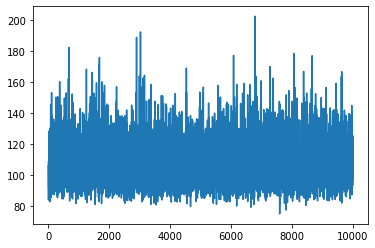

In [6]:
print('Plotting Sequence')
plt.plot(trainSeq)
plt.show()

In [7]:
x = trainSeq[:n-1, np.newaxis]
y = np.squeeze(trainSeq[1:, np.newaxis])

In [8]:
timeModel = model.Model(
    memorySize = 40,
    windowSize = 5,
    threshold = 140,
    inputDimension = 1,
    hiddenStateSize = 20,
    extremeValueIndex = 2.0,
    optimizer = tf.keras.optimizers.Adam(),
    extremeLossWeight = 50.0
)

In [9]:
timeModel.train(x, y, 200, verbose = 2, modelFilepath = 'trainModel3.model')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

start timestep: 6 | end timestep: 205  | time taken:  45.29 sec | Total Loss: 10449.4619140625 | Square Loss: 8625.814453125 | Extreme Loss (wt): 1823.6474609375
start timestep: 206 | end timestep: 405  | time taken:  45.68 sec | Total Loss: 12156.078125 | Square Loss: 7666.03662109375 | Extreme Loss (wt): 4490.04150390625
start timestep: 406 | end timestep: 605  | time taken:  46.56 sec | Total Loss: 10406.203125 | Square Loss: 7684.5478515625 | Extreme Loss (wt): 2721.65576171875
start timestep: 606 |

start timestep: 9206 | end timestep: 9405  | time taken:  43.30 sec | Total Loss: 7612.35107421875 | Square Loss: 3973.62890625 | Extreme Loss (wt): 3638.72216796875
start timestep: 9406 | end timestep: 9605  | time taken:  44.62 sec | Total Loss: 7823.7998046875 | Square Loss: 4176.5048828125 | Extreme Loss (wt): 3647.294677734375
start timestep: 9606 | end timestep: 9805  | time taken:  42.58 sec | Total Loss: 7106.4306640625 | Square Loss: 4315.69775390625 | Extreme Loss (wt): 2790.733154296875
start timestep: 9806 | end timestep: 9998  | time taken:  41.19 sec | Total Loss: 4884.740234375 | Square Loss: 3042.671875 | Extreme Loss (wt): 1842.068115234375


In [10]:
yPred = timeModel.predict(x[0:8000])

In [11]:
yTrue = np.squeeze(y[0:8000])

In [15]:
print(yTrue[0:20])

[100.7739256   87.19823895  83.93593524 108.79749921  99.748695
 102.12926466  95.25761378  99.94410437  91.393037   103.50442877
 102.76666194 109.03808615 113.58645033  89.66708007 120.58165805
  99.24288849 121.17698953 109.69591027  89.0794022  107.16785615]


In [16]:
print(yPred[0:20])

[34.941605 53.143063 45.962994 42.19109  53.523163 50.99562  51.97298
 48.300823 50.45727  46.604427 51.890118 51.87164  55.085052 57.15388
 46.71019  59.530407 50.851505 60.832462 55.555267 46.618637]


In [14]:
timeModel.b

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.20157441>